# Using the Gradient Boosting Classifier for an imbalanced data set

Date created: Jan 11, 2017   
Last modified: Jan 12, 2017  
Tags: GBM, hyperopt, imbalanced data set, semiconductor data   
About: Classify imbalanced semicondutor manufacturing data set using the Gradient Boosting Machine. Weight imbalanced classes using `sample_weight`. Tune hyperparameters manually and algorithmically using `hyperopt`.

<h3>I. Introduction</h3>

The [SECOM dataset](http://archive.ics.uci.edu/ml/datasets/SECOM) in the  [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml) is semicondutor manufacturing data. There are 1567 records, 590 anonymized features and 104 fails. This makes it an imbalanced dataset with a 14:1 ratio of pass to fails. The process yield has a simple pass/fail response (encoded -1/1).

<h4>Objective</h4>
We consider some of the different approaches to classify imbalanced data. There are two strategies available when working with highly imbalanced classes:  

- cost sensitive learning (penalizing misclassification of the minority class)
- resampling to balance the classes

In previous exercises we looked at the [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) and [SVM+oversampling using SMOTE](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_svm_smote.ipynb). (The full list of methods we have looked can be found [here](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/README.md)). In this exercise we consider the [Gradient Boosting (GBM)](https://en.wikipedia.org/wiki/Gradient_boosting) classifier which is an ensemble method that has been shown to [perform very well](https://www.youtube.com/watch?v=GTs5ZQ6XwUM#t=7m04s) in machine learning competitions. To implement a cost-sensitive GBM, the GBM `fit` method with the `sample_weight` option is used to weigh individual observations.  
 
<h4>Methodology</h4>
The *sklearn* [GBM Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) module uses the `sample_weight` mask to assign a vector of weights to corresponding observations. To balance the two classes, we will weigh them in inverse proportion to their respective class frequencies. 

At each stage, the boosting algorithm will fit the residuals from the previous step. We need to determine if the data needs to be reweighted in order to get optimal results. We will look at:
- the baseline case (with equal class weights)
- sample weights (in inverse proportion to the class frequencies)  

In addition, since hyperparameter tuning is an important part of GBM performance, we will look at:
- Manual selection of parameters
- Hyperparameter optimization with cross validation using `hyperopt`
- Grid search optimization with cross validation  

We will see if any of these three parameter selection methods suggest the use of default versus sample weights.

<h4>Preprocessing</h4>
Like the Random Forest (RF) classifier, the GBM can handle continuous and categorical varibles and does not require transformations or preprocessing such as one-hot encoding or scaling. The only preprocessing needed is with regards to the missing data.
For this data set, the measurements come from a large number of processes or sensors and many of the records are missing. In addition some measurements are identical/constant and so not useful for prediction. We will remove the columns that have high missing counts or constant values and estimate values for the rest of the missing data. These are the same steps used for the [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) and a more detailed explanation can be seen there. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report,\
roc_auc_score, accuracy_score
from sklearn.metrics import make_scorer, matthews_corrcoef

from time import time
from __future__ import division
import warnings
warnings.filterwarnings("ignore")

SEED = 7  # random state

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom = pd.read_table(url, header=None, delim_whitespace=True)

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_table(url, header=None, usecols=[0], squeeze=True, delim_whitespace=True)

print 'The dataset has {} observations/rows and {} variables/columns.' \
       .format(secom.shape[0], secom.shape[1])
print 'The ratio of majority class to minority class is {}:1.' \
      .format(int(y[y == -1].size/y[y == 1].size))

The dataset has 1567 observations/rows and 590 variables/columns.
The ratio of majority class to minority class is 14:1.


<h3>II. Preprocessing </h3>

We process the missing values first, dropping columns which have a large number of missing values and imputing values for those that have only a few missing values.
The [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) exercise has a more detailed version of these steps.

In [3]:
# dropping columns which have large number of missing entries 

m = map(lambda x: sum(secom[x].isnull()), xrange(secom.shape[1]))
m_200thresh = filter(lambda i: (m[i] > 200), xrange(secom.shape[1]))
secom_drop_200thresh = secom.dropna(subset=[m_200thresh], axis=1)
dropthese = [x for x in secom_drop_200thresh.columns.values if \
             secom_drop_200thresh[x].std() == 0]
secom_drop_200thresh.drop(dropthese, axis=1, inplace=True)

print 'The SECOM data set now has {} variables.'\
      .format(secom_drop_200thresh.shape[1])
    

The SECOM data set now has 409 variables.


In [4]:
# imputing missing values for the random forest

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
secom_imp = imp.fit_transform(secom_drop_200thresh)

<h3>III. GBM: baseline vs using sample_weight</h3>  

We will first compare baseline results with the performance of a model where the `sample_weight` is used. As discussed in [previous exercises](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/README.md), the <i>Matthews correlation coefficient (MCC)</i> is used instead of the <i>Accuracy</i> to compute the score.

In [5]:
# split data into train and holdout sets
# stratify the sample used for modeling to preserve the class proportions

X_train, X_test, y_train, y_test = tts(secom_imp, y, \
                                       test_size=0.2, stratify=y, random_state=5)

In [6]:
# function to test GBC parameters

def GBC(params, weight):
    
    clf = GradientBoostingClassifier(**params)
                            
    if weight:
        sample_weight = np.array([14 if i == -1 else 1 for i in y_train])
        clf.fit(X_train, y_train, sample_weight)
    else:
        clf.fit(X_train, y_train)
    
    print_results(clf, X_train, X_test)

    
# function to print results
def print_results(clf, X_train, X_test):        
    # training data results  
    print 'Training set results:'
    y_pred = clf.predict(X_train)
    print 'The train set MCC: {0:4.3f}'\
    .format(matthews_corrcoef(y_train, y_pred))
    
    # test set results
    print '\nTest set results:'
    acc = clf.score(X_test, y_test)
    print("Accuracy: {:.4f}".format(acc))
                             
    y_pred = clf.predict(X_test)
    print '\nThe confusion matrix: '
    cm = confusion_matrix(y_test, y_pred)
    print cm
    print '\nThe test set MCC: {0:4.3f}'\
    .format(matthews_corrcoef(y_test, y_pred))

<h4>A) Baseline</h4>

In [7]:
params = {'n_estimators': 800, 'max_depth': 3, 'subsample': 0.8, 'max_features' : 'sqrt',
          'learning_rate': 0.019, 'min_samples_split': 2, 'random_state': SEED}
GBC(params, 0)

Training set results:
The train set MCC: 0.987

Test set results:
Accuracy: 0.9331

The confusion matrix: 
[[291   2]
 [ 19   2]]

The test set MCC: 0.197


<h4>B) Sample weight</h4>

In [8]:
# RUN 1 Using the same parameters as the baseline

params = {'n_estimators': 800, 'max_depth': 3, 'subsample': 0.8, 'max_features' : 'sqrt', 
          'learning_rate': 0.019, 'min_samples_split': 2, 'random_state': SEED}
GBC(params, 1)

Training set results:
The train set MCC: 0.608

Test set results:
Accuracy: 0.9140

The confusion matrix: 
[[285   8]
 [ 19   2]]

The test set MCC: 0.097


In [9]:
# RUN 2 Manually selecting parameters to optimize the train/test MCC with sample weights

params = {'n_estimators': 800, 'max_depth': 3, 'subsample': 0.7, 'max_features' : 'log2', 
          'learning_rate': 0.018, 'min_samples_split': 2, 'random_state': SEED}

GBC(params, 1)

Training set results:
The train set MCC: 0.664

Test set results:
Accuracy: 0.9331

The confusion matrix: 
[[290   3]
 [ 18   3]]

The test set MCC: 0.242


In the baseline case (where we do not adjust the weights), we get a high MCC score for the training set (0.97). The test MCC is 0.197 so there is a large gap between the train and test MCC. When sample weights are used, we get a test set MCC of 0.242 after tuning the parameters. 

The tuning parameters play a big role in the performance of the GBM. In Section III (D) we will look at the MCC trend over the number of estimators. This will allow us to adjust the complexity of the model. In Sections IV and V  we will use the `hyperopt` and `gridsearchCV` modules to select the hyperparameters.

<h4>C) Feature importance</h4>  

Here we compute the feature importance (using the baseline parameters) for the GBM. We also compare the results with the feature importance for the Random Forest.

In [10]:
params = {'n_estimators': 800, 'max_depth': 3, 'subsample': 0.8, 'max_features' : 'sqrt', 
          'learning_rate': 0.019, 'min_samples_split': 2, 'random_state': SEED}

# GBM
clf = GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
gbm_importance = clf.feature_importances_
gbm_ranked_indices = np.argsort(clf.feature_importances_)[::-1]

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=7)
rf.fit(X_train, y_train)
rf_importance = rf.feature_importances_
rf_ranked_indices = np.argsort(rf.feature_importances_)[::-1]

# printing results in a table
importance_results = pd.DataFrame(index=range(1,16), 
                                  columns=pd.MultiIndex.from_product([['GBM','RF'],['Feature #','Importance']]))
importance_results.index.name = 'Rank'
importance_results.loc[:,'GBM'] =  list(zip(gbm_ranked_indices[:15], 
                                            gbm_importance[gbm_ranked_indices[:15]]))
importance_results.loc[:,'RF'] =  list(zip(rf_ranked_indices[:15], 
                                           rf_importance[rf_ranked_indices[:15]]))
print importance_results

           GBM                   RF           
     Feature # Importance Feature # Importance
Rank                                          
1           61   0.022117        55   0.016726
2           56   0.018574        50   0.010880
3           55   0.017534        56   0.010454
4          131   0.015305       265   0.009200
5           50   0.013360       131   0.008128
6           22   0.012942       130   0.008107
7          311   0.012862       203   0.008095
8           43   0.011589       311   0.007529
9          203   0.010597       106   0.007180
10          17   0.010526       321   0.007113
11          65   0.009741       230   0.007104
12         177   0.009733       269   0.006803
13         267   0.009610        89   0.006785
14          85   0.009479       176   0.006750
15         230   0.009351       250   0.006571


Roughly half the top fifteen most important features for the GBM were also the top fifteen computed for the Random Forest classifier. There are complex interactions between the parameters so we do not expect the two classifiers to give the same results. In Section IV where we optimize the hyperparameters, the `nvar` (number of variables) parameter will select variables according to their ranked importance.

<h4>D) Number of estimators -- model complexity</h4>

The GBM sequentially fits the function and the number of steps (the number of estimators) is specified by the `ntree` parameter. At some stage, the model complexity increases to the point where we start overfitting the data. Here we will plot the MCC as a function of the number of estimators for the train set and test set to determine a good value for `ntree`.   

When <i>Accuracy</i> is used as score, a plot of <i>Classification Error</i> (= <i>1 - Accuracy</i>) versus the <i>Number of Trees</i> can be used as a diagnostic to determine bias and overfitting. The term <i>(1 - MCC)</i>, however, is hard to interpret since MCC is calculated with all four terms of the confusion matrix. (I did make those plots out of curiosity and the trends are similar to those seen in an "Error vs no. of estimators" plot an example of which is presented on Slide 3 of [this](https://lagunita.stanford.edu/c4x/HumanitiesScience/StatLearning/asset/cv_boot.pdf) Hastie/Tibshirani lecture).

In [11]:
# function to compute MCC vs number of trees

def GBC_trend(weight):
    base_params = {'max_depth': 3, 'subsample': 0.8, 'max_features' : 'sqrt',
                   'learning_rate': 0.019, 'min_samples_split': 2, 'random_state': SEED}

    mcc_train = []
    mcc_test = []

    for i in range(500, 1600, 100):
        params = dict(base_params)
        ntrees = {'n_estimators': i}
        params.update(ntrees)
    
        clf = GradientBoostingClassifier(**params)
        if weight:
            sample_weight = np.array([14 if i == -1 else 1 for i in y_train])
            clf.fit(X_train, y_train, sample_weight)
        else:
            clf.fit(X_train, y_train)
    
        y_pred_train = clf.predict(X_train)
        mcc_train.append(matthews_corrcoef(y_train, y_pred_train))
        y_pred_test = clf.predict(X_test)
        mcc_test.append(matthews_corrcoef(y_test, y_pred_test))
    
    return mcc_train, mcc_test

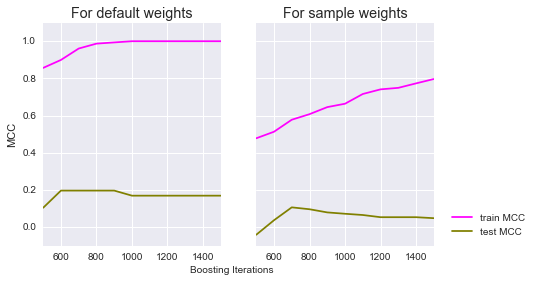

In [12]:
# plot

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7,4))
plt.style.use('ggplot')

mcc_train, mcc_test = GBC_trend(0)
ax[0].plot(range(500, 1600, 100), mcc_train, color='magenta', label='train MCC' )
ax[0].plot(range(500, 1600, 100), mcc_test, color='olive', label='test MCC' )
ax[0].set_title('For default weights')

mcc_train, mcc_test = GBC_trend(1)
ax[1].plot(range(500, 1600, 100), mcc_train, color='magenta', label='train MCC' )
ax[1].plot(range(500, 1600, 100), mcc_test, color='olive', label='test MCC' )
ax[1].set_title('For sample weights')

ax[0].set_ylabel('MCC')
fig.text(0.5, 0.04, 'Boosting Iterations', ha='center', va='center')
plt.xlim(500,1500)
plt.ylim(-0.1, 1.1);
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left');

Default weight option (left): After about 900 iterations, the GBM models all the training data perfectly. At the same time, there is a large gap in the holdout data classification results.  This is a classic case of overfitting.  

Sample weight option (right): This plot was constructed using the same parameters at the default weight plot. This may account for some of the bias (lower values for MCC) we see for the training data line. From III B, we can see that even when we tune the parameters for the sample weight model, the MCC for the training set is lower that for the default weight model. This gives us some indication that using sample weights adds bias.

<h3>IV. Hyperparameter optimization using Hyperopt</h3>  

The python `hyperopt` module by James Bergstra uses Bayesian optimization (based on a tree-structured Parzen density estimate--TPE) <a href="#ref1">[1]</a> to automatically select the best hyperparameters. [This](https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt) blog post provides examples of how this can be used with <i>sklearn</i> classifiers. We will use the <i>MCC</i> instead of the <i>Accuracy</i> for the cross-validation score. Note that since the `hyperopt` function `fmin` will minimze the MCC, we need to negate the MCC to maximize its value.

In [13]:
# defining the MCC metric to assess cross-validation

def mcc_score(y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    return mcc
    
mcc_scorer = make_scorer(mcc_score, greater_is_better=True)

In [14]:
# convert to DataFrame for easy indexing of number of variables (nvar)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def hyperopt_train_test(params):
    
    weight = params['weight']
    X_ = X_train.loc[:, gbm_ranked_indices[:params['nvar']]]
    del params['nvar'], params['weight']
   
    clf = GradientBoostingClassifier(**params)
    if weight:
        sample_weight = np.array([14 if i == -1 else 1 for i in y_train])
        return cross_val_score(clf, X_, y_train, scoring=mcc_scorer,\
                               fit_params={'sample_weight': sample_weight}).mean()
    else: 
       return cross_val_score(clf, X_, y_train, scoring=mcc_scorer).mean()

space = {
    'n_estimators': hp.choice('n_estimators', range(700,1300, 100)),
    'max_features': hp.choice('max_features',  ['sqrt', 'log2']),
    'max_depth': hp.choice('max_depth', range(2,5)),
    'subsample': hp.choice('subsample', [0.6, 0.7, 0.8, 0.9]),
    'min_samples_split': hp.choice('min_samples_split', [2, 3]), 
    'learning_rate': hp.choice('learning_rate', [0.01, 0.015, 0.018, 0.02, 0.025]),
    'nvar': hp.choice('nvar', [200, 300, 400]),
    'weight': hp.choice('weight', [0, 1]),  # select sample_weight or default
    'random_state': SEED
 }  

def f(params):
    mcc = hyperopt_train_test(params)
    # with a negative sign, we maximize the MCC
    return {'loss': -mcc, 'status': STATUS_OK}

<h4>Run 1</h4>

In [22]:
start = time()
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
print("HyperoptCV took %.2f seconds."% (time() - start))
print '\nBest parameters (by index):'
print best

HyperoptCV took 369.96 seconds.

Best parameters (by index):
{'weight': 1, 'nvar': 0, 'learning_rate': 2, 'n_estimators': 5, 'subsample': 1, 'min_samples_split': 1, 'max_features': 1, 'max_depth': 1}


We will apply the optimal hyperparameters selected via `hyperopt` above to the GBM classifier. The optimal parameters include `nvar`= 200 and the use of `sample_weight`.

In [23]:
params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.7, 'max_features' : 'log2', 
          'learning_rate': 0.018, 'min_samples_split': 3, 'random_state': SEED}

train_ = X_train.loc[:, gbm_ranked_indices[:200]]
test_ = X_test.loc[:, gbm_ranked_indices[:200]]

clf = GradientBoostingClassifier(**params)
sample_weight = np.array([14 if i == -1 else 1 for i in y_train])
clf.fit(train_, y_train, sample_weight)
        
print_results(clf, train_, test_)

Training set results:
The train set MCC: 0.773

Test set results:
Accuracy: 0.8949

The confusion matrix: 
[[280  13]
 [ 20   1]]

The test set MCC: 0.004


<h4>Run 2</h4>  
I repeated the run with `hyperopt` a few times and in each case the optimal parameters include `nvar`= 200 and the use of `sample_weight`.  There is a great deal of variability among the remaining parameters selected across the runs. This is an example of a second run.

In [24]:
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
print '\nBest parameters (by index):'
print best


Best parameters (by index):
{'weight': 1, 'nvar': 0, 'learning_rate': 2, 'n_estimators': 0, 'subsample': 2, 'min_samples_split': 0, 'max_features': 1, 'max_depth': 2}


In [25]:
params = {'n_estimators': 700, 'max_depth': 4, 'subsample': 0.8, 'max_features' : 'log2', 
          'learning_rate': 0.018, 'min_samples_split': 2, 'random_state': SEED}

train_ = X_train.loc[:, gbm_ranked_indices[:200]]
test_ = X_test.loc[:, gbm_ranked_indices[:200]]

clf = GradientBoostingClassifier(**params)
sample_weight = np.array([14 if i == -1 else 1 for i in y_train])
clf.fit(train_, y_train, sample_weight)
        
print_results(clf, train_, test_)

Training set results:
The train set MCC: 0.741

Test set results:
Accuracy: 0.9045

The confusion matrix: 
[[282  11]
 [ 19   2]]

The test set MCC: 0.072


<h4> Run 3 -- default weight</h4>  
For both Run 1 and Run 2, `hyperopt` selected the `sample_weight` option. This was the case for most of the runs though there were a few instances in which the default option was selected. This is an example:

In [31]:
start = time()
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
print("HyperoptCV took %.2f seconds."% (time() - start))
print '\nBest parameters (by index):'
print best

HyperoptCV took 370.07 seconds.

Best parameters (by index):
{'weight': 0, 'nvar': 0, 'learning_rate': 4, 'n_estimators': 3, 'subsample': 3, 'min_samples_split': 1, 'max_features': 1, 'max_depth': 0}


In [32]:
params = {'n_estimators': 1000, 'max_depth': 2, 'subsample': 0.9, 'max_features' : 'log2', 
          'learning_rate': 0.025, 'min_samples_split': 3, 'random_state': SEED}

train_ = X_train.loc[:, gbm_ranked_indices[:200]]
test_ = X_test.loc[:, gbm_ranked_indices[:200]]

clf = GradientBoostingClassifier(**params)
clf.fit(train_, y_train)
    
print_results(clf, train_, test_)

Training set results:
The train set MCC: 0.913

Test set results:
Accuracy: 0.9204

The confusion matrix: 
[[287   6]
 [ 19   2]]

The test set MCC: 0.119


The results from `hyperopt` (tested over ten or more runs) were quite variable and no conclusions can be made. By seeding the `random_state` parameter, we should be able to get reproducible results but since this was not the case here, we will need to investigate this further.

<h3>V. Grid search with cross-validation</h3>

In [11]:
# cv function

def GBMCV(weight):
    
    clf = GradientBoostingClassifier(random_state=SEED)

    param_grid = {"n_estimators": [800, 900, 1000, 1200],
                  "max_depth": [2, 3],
                  "subsample": [0.6, 0.7, 0.8],
                  "min_samples_split": [2, 3],
                  "max_features": ["sqrt", "log2"],
                  "learning_rate": [0.01, 0.015, 0.018, 0.02, 0.025]}
              
    # run grid search
    if weight:
        sample_weight = np.array([14 if i == -1 else 1 for i in y_train])
        grid_search = GridSearchCV(clf, param_grid=param_grid,  scoring=mcc_scorer, \
                                   fit_params={'sample_weight': sample_weight})
    else:
        grid_search = GridSearchCV(clf, param_grid=param_grid,  scoring=mcc_scorer)
        
    start = time()
    grid_search.fit(X_train, y_train)

    # print results
    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
     % (time() - start, len(grid_search.grid_scores_)))

    print 'The best parameters:'
    print '{}\n'. format(grid_search.best_params_)

    print 'Results for model fitted with the best parameter:'
    y_true, y_pred = y_test, grid_search.predict(X_test)
    print(classification_report(y_true, y_pred))

    print 'The confusion matrix: '
    cm = confusion_matrix(y_true, y_pred)
    print cm

    print '\nThe Matthews correlation coefficient: {0:4.3f}'\
    .format(matthews_corrcoef(y_test, y_pred))

In [14]:
# CV with default weights

print "CV with default weights:"
GBMCV(0)

CV with default weights:
GridSearchCV took 1802.75 seconds for 480 candidate parameter settings.
The best parameters:
{'subsample': 0.7, 'learning_rate': 0.025, 'n_estimators': 1000, 'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 2}

Results for model fitted with the best parameter:
             precision    recall  f1-score   support

         -1       0.94      0.99      0.96       293
          1       0.25      0.05      0.08        21

avg / total       0.89      0.93      0.90       314

The confusion matrix: 
[[290   3]
 [ 20   1]]

The Matthews correlation coefficient: 0.083


In [10]:
# CV with sample weights

GBMCV(1)

The best parameters:
{'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 800, 'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 2}

Results for model fitted with the best parameter:
             precision    recall  f1-score   support

         -1       0.93      0.96      0.95       293
          1       0.08      0.05      0.06        21

avg / total       0.88      0.90      0.89       314

The confusion matrix: 
[[282  11]
 [ 20   1]]

The Matthews correlation coefficient: 0.013


<h3>VI. Summary</h3>

In this exercise the GBM was used to classify imbalanced data. In looking at the GBM classifier we need to consider the following:
(1) whether the GBM is superior to other methods we have looked at and
(2) whether reweighting with sample weights will improve classification results

On the issue of the GBM classifier performance (classification results/time/ease of use) it should be noted that tuning the GBM is no simple matter as there are many complex interactions between the parameters. We use the three methods -- manual selection, automatic hyperparameter optimization using a Bayesian strategy and grid search cross validation -- available but they give variable results. At the same time the best classification results obtained (an MCC of 0.24 for the holdout data) show that there is no obvious advantage to using the GBM over a simpler sampling strategy (see [SVM+undersampling](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_svm_undersampling.ipynb)).

On the question of rebalancing with `sample_weight`, once again it is not clear that rebalancing gives better results. When the parameters were manually selected, both the default and weighted GBM showed results comparable to other classifiers such as the [Random Forest](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_rf.ipynb). The `hyperopt` selected the sample_weight over the default in at least 9/10 runs (not all runs are shown in Section IV) but the holdout MCC was not good (e.g. 0.004). For the gridsearch crossvalidation, results for default vs sample_weight were comparable.

In previous exercises we had experimented with [SVM+oversampling using SMOTE](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_svm_smote.ipynb) and [SVM+undersampling](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_svm_undersampling.ipynb). Our experiments thus far indicate that SVM combined with a sampling strategy holds promise and we  will next look at a combination of oversampling (the minority class) and undersampling (the majority class).

<h3>VII. References and Further Reading </h3>

<a name="ref1"></a>[1] [Bergstra, James S., et al. “Algorithms for hyper-parameter optimization.” Advances in Neural Information Processing Systems. (2011)](http://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

<div style="background-color: #FAAC58; margin-left: 0px; margin-right: 20px; padding-bottom: 8px; padding-left: 8px; padding-right: 8px; padding-top: 8px;">


Author:  Meena Mani  <br>
email:   meenas.mailbag@gmail.com   <br> 
twitter: @meena_uvaca    <br>
</div>